# Titanic Disaster

## Introduction

It's a classic for beginners, a go-to, this is a very straight-forward approach using classic statistics algorithms (Logistic Regression and Random Forest), and an uprising XGBoost.

The idea is to predict the survivance, and to discover what contributes(d) to the survivance. Feature engineering is not only allowed, but encouraged.

### References

- https://www.kaggle.com/c/titanic

### Features

- **Survival** -> Survival
- **Pclass** -> Ticket class
- **Sex** -> Sex
- **Age** -> Age in years 	
- **Sibsp** -> # of siblings / spouses aboard the Titanic 	
- **Parch** -> # of parents / children aboard the Titanic 	
- **Ticket** -> Ticket number 	
- **Fare** -> Passenger fare 	
- **Cabin** -> Cabin number 	
- **Embarked** -> Port of Embarkation

## Initialization

Base configuration variables, we'll need them for later

In [1]:
RANDOM_SEED = 0 #@param {type:'integer'}
DEV_RANDOM_SEED = 42 #@param {type:'integer'}

SHOW_PROGRESS = True #@param {type:'boolean'}
DEV_SHOW_PROGRESS = True #@param {type:'boolean'}

SUBMIT_ANSWER = True #@param {type:'boolean'}
DEV_SUBMIT_ANSWER = False #@param {type:'boolean'}

DEVELOPMENT_ENVIRONMENT = True #@param {type:'boolean'}

if DEVELOPMENT_ENVIRONMENT:
  RANDOM_SEED = DEV_RANDOM_SEED
  SHOW_PROGRESS = DEV_SHOW_PROGRESS
  SUBMIT_ANSWER = DEV_SUBMIT_ANSWER

### Imports

In [2]:
import pandas as pd
import numpy as np
np.random.seed(RANDOM_SEED)
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil, floor

### Load the dataset

We need our kaggle.json, I'll mount my drive, but no need to do so if you've already authenticated yourself locally

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


We'll first need to configure Kaggle for our environment

In [5]:
%pip install kaggle -q
%cp "/content/drive/MyDrive/Colab Notebooks/Kaggle/jofaval-kaggle.json" "kaggle.json"
%mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

So we can now download the competition dataset

In [258]:
!kaggle competitions download -c titanic -q
!unzip -oq titanic.zip

And load our data, we'll print just the shape to make sure that everything is okay

In [763]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [764]:
df_train.shape

(891, 12)

## Data Cleansening and Preprocessing

Before we can even explore anything, we need to prepare the data for it to be ready.

There's missing values, abnormal ones, values that are non-numeric, there's stuff to work on.

In [765]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [766]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


### Missing values

Whenever a row has empty columns, basically, null values.

The info attribute can give us so many details at once: rows, missing values, d(ata)types, column names...

In [767]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


We can also plot the missing values, which may be easier to visualize, and, if you're dislexic, it's easier to conceptualize it this way, no mistaking.

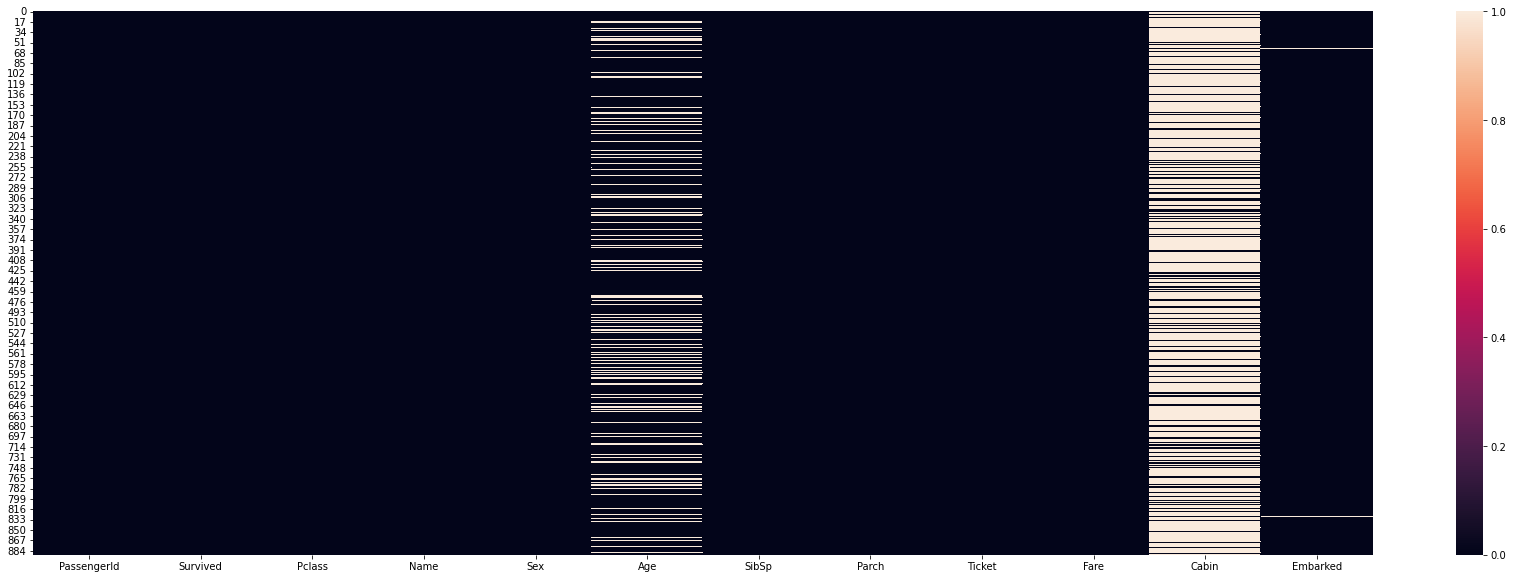

In [768]:
if SHOW_PROGRESS:
  plt.figure(figsize=(30, 10))
  sns.heatmap(df_train.isna())

Since we're working with two dataframes, we'll be creating functions to apply the same logic twice. In this case, Cabin has waayyyy too many values, but with Age and Embarked? we can work around them no worries (almost) 

In [769]:
def clean_dataset(
  dataframe: pd.DataFrame
) -> pd.DataFrame:
  df = dataframe.copy(deep=True)
  # df = df.dropna(subset=['Age', 'Embarked'])
  df = df.drop(columns=['Cabin'])

  return df

In [770]:
df_train = clean_dataset(df_train)
df_test = clean_dataset(df_test)

### Types and standarization

As aforementioned, we have non-numeric values, our models (and some visualizations) work only with numbers. We need to transform those values so they're understandable by the computer in the way that we want them to.

We'll first visualize all the data types

In [771]:
df_train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Embarked        object
dtype: object

We can 

In [772]:
df_train.select_dtypes(exclude=np.number).dtypes

Name        object
Sex         object
Ticket      object
Embarked    object
dtype: object

In [773]:
df_train[ ['Name', 'Sex', 'Ticket', 'Embarked'] ]

,Name,Sex,Ticket,Embarked
0,"Braund, Mr. Owen Harris",male,A/5 21171,S
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,PC 17599,C
2,"Heikkinen, Miss. Laina",female,STON/O2. 3101282,S
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,113803,S
4,"Allen, Mr. William Henry",male,373450,S
...,...,...,...,...
886,"Montvila, Rev. Juozas",male,211536,S
887,"Graham, Miss. Margaret Edith",female,112053,S
888,"Johnston, Miss. Catherine Helen ""Carrie""",female,W./C. 6607,S
889,"Behr, Mr. Karl Howell",male,111369,C


We can see the total values, Embarked, for example, could be one hot encoded

In [774]:
df_train['Embarked'].unique()

array(['S', 'C', 'Q', nan], dtype=object)

Meanwhile, Ticket will have to undergo a manual transformation

In [775]:
len(df_train['Ticket'].unique())

681

#### Age

Age will be a very specific transformation, we'll apply some feature engineering

In [776]:
def standarize_age(
  dataframe: pd.DataFrame,
  age_column: str = 'Age',
  age_categories: int = 10,
  categorize: bool = True,
  drop_age: bool = True,
) -> pd.DataFrame:
  df = dataframe.copy(deep=True)
  df['is_baby'] = np.where((df[age_column] < 2), 1, 0)
  df['is_kiddo'] = np.where((df[age_column] >= 2) & (df[age_column] < 13), 1, 0)
  df['is_teenager'] = np.where((df[age_column] >= 13) & (df[age_column] < 21), 1, 0)
  df['is_adult'] = np.where((df[age_column] >= 21) & (df[age_column] < 75), 1, 0)
  df['is_old'] = np.where((df[age_column] >= 75), 1, 0)

  # we could extract the missing value information,
  # but having all of the above at zero will already represent that
  # df['without_age'] = np.where((df[age_column].isna()), 1, 0)

  if drop_age:
    df = df.drop(columns=[age_column])
  elif categorize:
    temp = pd.cut(df[age_column].fillna(0), age_categories, retbins=True)[0]
    df[age_column] = temp.cat.codes

  return df

A Sex dictionary will help us later, and it's a neat way to identify which number represents which sex

In [777]:
sex_dict = {'male': 0, 'female': 1}

#### Overall

All of the transformations at once.

In [778]:
def standarize_dataset(
  dataframe: pd.DataFrame
) -> pd.DataFrame:
  df = dataframe.copy(deep=True)
  # df['Embarked'] = pd.factorize(df['Embarked'])[0]
  df = pd.get_dummies(df, columns=['Embarked'])

  # df['Sex'] = pd.factorize(df['Sex'])[0]
  df['Sex'] = df['Sex'].apply(lambda x: sex_dict[x])

  df = standarize_age(df)

  # df['Ticket'] = df['Ticket'].apply(lambda x: str(x).split()[-1])
  df = df.drop(columns=['Name', 'Ticket'])

  # dropna is disabled, not because it's not a good option, but because we'll need all of the rows later on
  # df = df.dropna(subset=['Age'])

  return df

In [779]:
df_train = standarize_dataset(df_train)
df_test = standarize_dataset(df_test)

In [780]:
# df_train = df_train.dropna(subset=['Age'])

In [781]:
if 'Ticket' in df_train:
  len(df_train['Ticket'].unique())

### Abnormal values

An abnormal value is something that does not make sense, for example, age being negative does not make sense, or a pclass being at five, or at zero, we know that's not possible because of the information that we got.

But luckily, none of that applies

In [782]:
df_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.0,223.5000,446.0000,668.5,891.0000
Survived,891.0,0.383838,0.486592,0.0,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.0,2.0000,3.0000,3.0,3.0000
Sex,891.0,0.352413,0.477990,0.0,0.0000,0.0000,1.0,1.0000
SibSp,891.0,0.523008,1.102743,0.0,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.0,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.0,7.9104,14.4542,31.0,512.3292
Embarked_C,891.0,0.188552,0.391372,0.0,0.0000,0.0000,0.0,1.0000
Embarked_Q,891.0,0.086420,0.281141,0.0,0.0000,0.0000,0.0,1.0000
Embarked_S,891.0,0.722783,0.447876,0.0,0.0000,1.0000,1.0,1.0000


We create the function just in case we want to patch some features later down the line

In [783]:
def patch_abnormal_values(
  dataframe: pd.DataFrame
) -> pd.DataFrame:
  df = dataframe.copy(deep=True)

  return df

In [784]:
df_train = patch_abnormal_values(df_train)
df_test = patch_abnormal_values(df_test)

### Filling values

To fill all of the missing values, we'll use an imputer, but imputing them with zeros is as good if not better

In [785]:
USE_IMPUTER = False #@param {type: 'boolean'}

We can either use the imputer, or fill the values with zeros

In [786]:
from sklearn.impute import SimpleImputer

if USE_IMPUTER:
  imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
  feature_cols = [ col for col in df_train.columns if col not in ['Survived'] ]

  imp_mean.fit(df_train[feature_cols])

  df_train[feature_cols] = pd.DataFrame(imp_mean.transform(df_train[feature_cols]), columns=feature_cols)
  df_test = pd.DataFrame(imp_mean.transform(df_test), columns=df_test.columns)
else:
  df_train = df_train.fillna(0)
  df_test = df_test.fillna(0)

So we can now have a filled dataframe with no missing values whatsoever

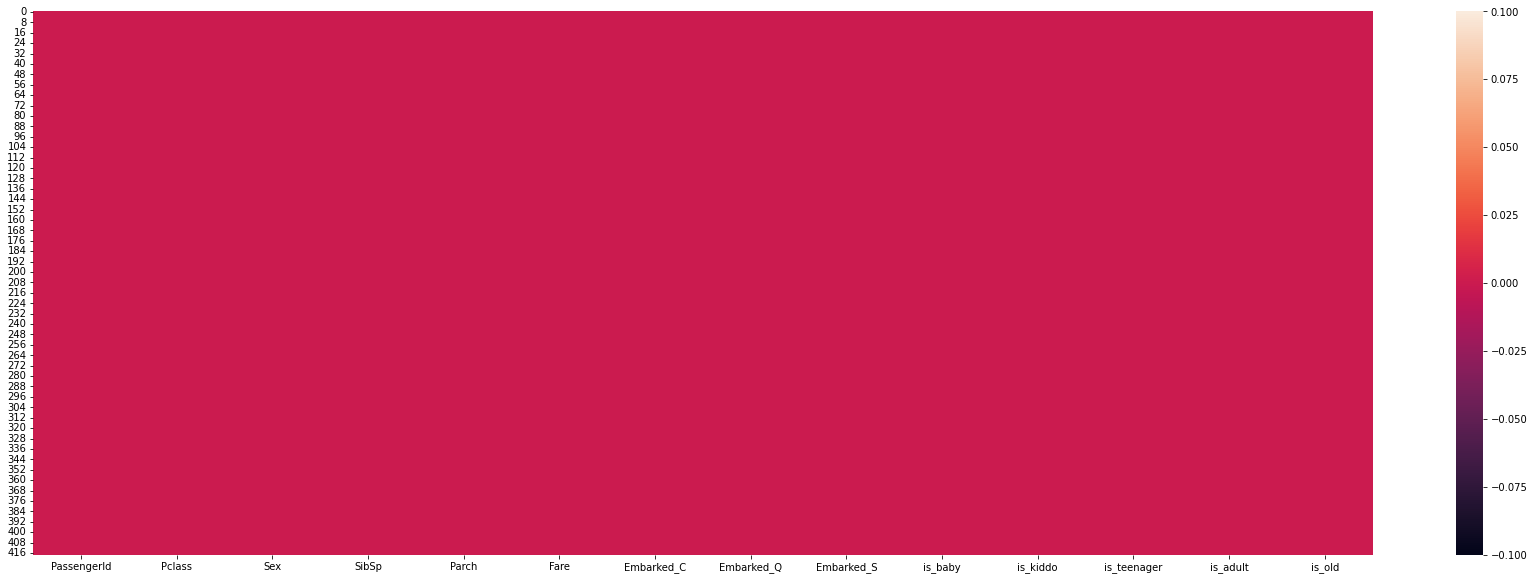

In [787]:
if SHOW_PROGRESS:
  plt.figure(figsize=(30, 10))
  sns.heatmap(df_test.isna())

## Exploratory Data Analysis

Now that we have our data preprocessed and clean, we could say we have quality data, it is time to analyze and understand what we'll be working with. See if we can get an hypothesis, detect any sort of pattern.

We can also detect any value too highly correlated in-between

### Outliers detection

An outlier is a value that's above or below a our first and last quater percentils, in other words, "out of the scope". They're important, but we have to be conscious of them

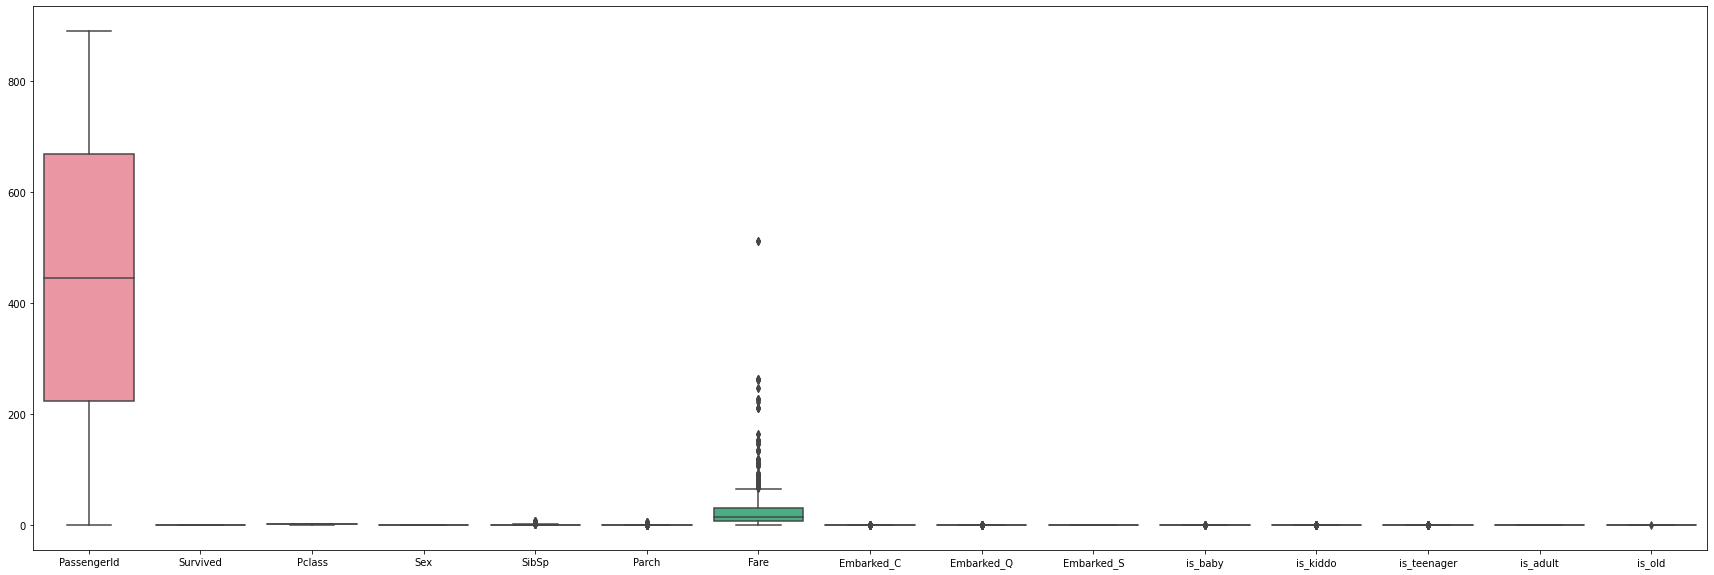

In [788]:
if SHOW_PROGRESS:
  plt.figure(figsize=(30, 10))
  sns.boxplot(data=df_train)

### Data distribution

Analyzing the data distribution can give insights as to where most of the values are, if we'll add bias or not. If we have a well distruted feature, it'll add more on the long run.

#### Histplot

Histplot, previously called distplot, is the distribution visualization by default

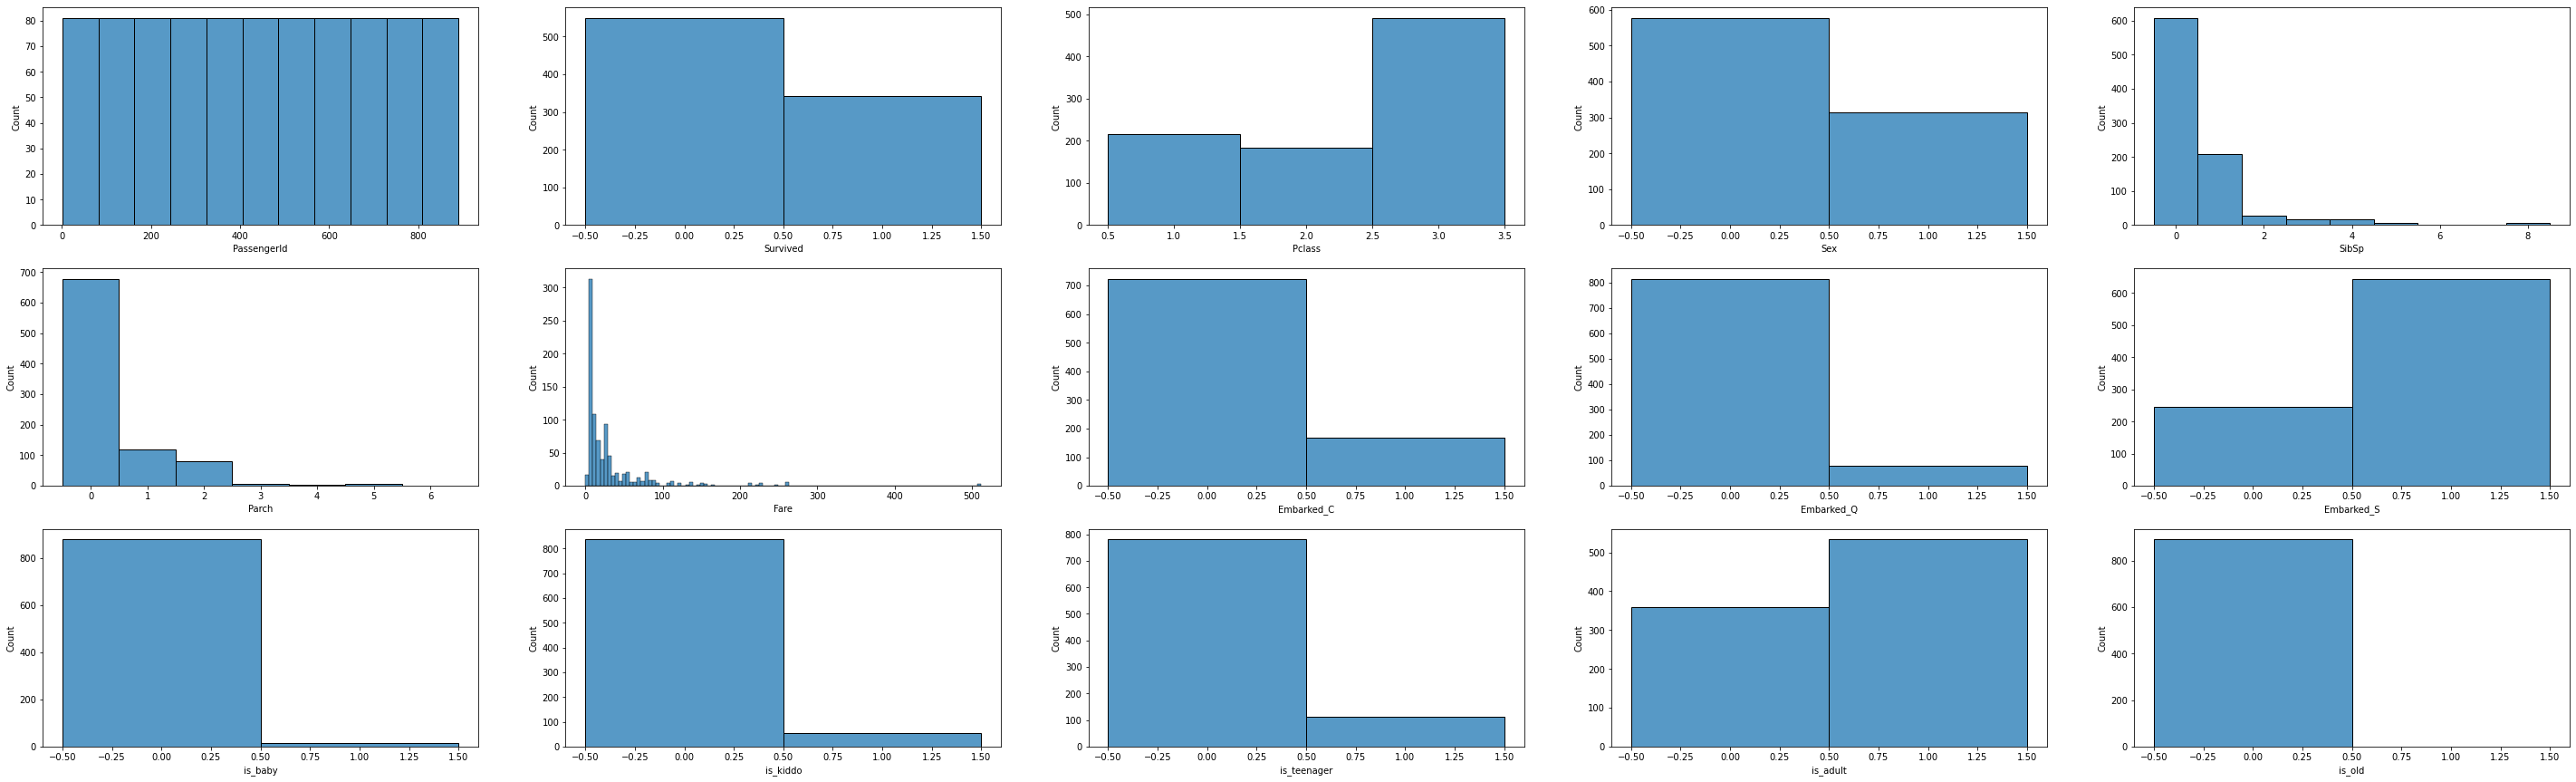

In [789]:
if SHOW_PROGRESS:
  n_cols = 5
  n_rows = ceil(len(df_train.columns) / n_cols)
  fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 10, n_rows * 5))
  for index, column in enumerate(df_train.columns):
    sns.histplot(data=df_train, x=column, ax=axes[
      int(index / n_cols),
      int(index % n_cols),
    ], discrete=len(df_train[column].unique()) <= 10)

#### Boxplot

With boxplot we can, not only see it's distribution, but the outliers in greater detail than before

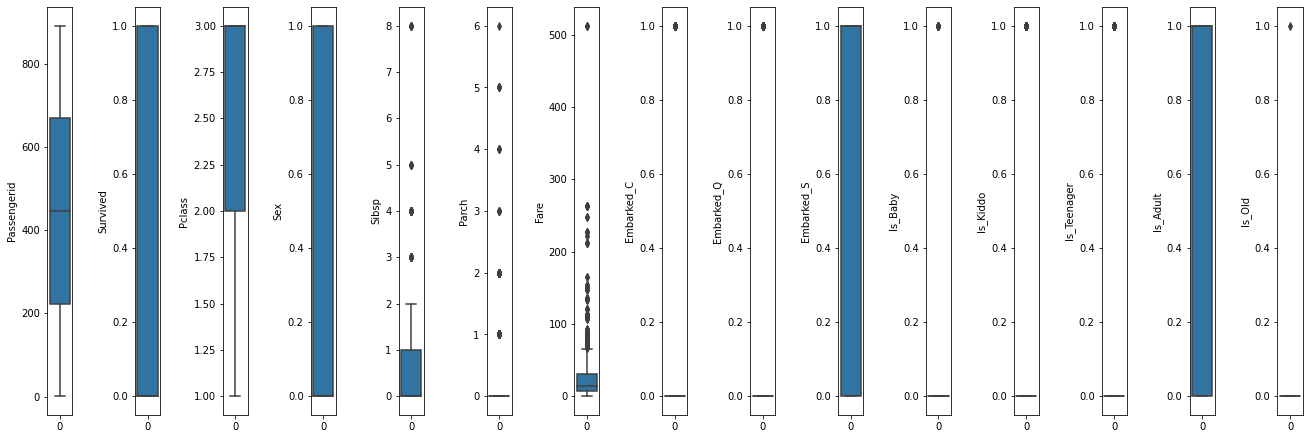

In [790]:
if SHOW_PROGRESS:
  columns = [ col for col in df_train.columns if not col.startswith('Embarked') ]
  columns = df_train.columns
  n_cols = len(df_train.columns)
  fig, axes = plt.subplots(1, n_cols, figsize=(n_cols * 1.5, 7.5))
  plt.subplots_adjust(wspace=2.5)
  for index, column in enumerate(df_train.columns):
    ax = axes[int(index % n_cols)]
    ax.set_ylabel(column.title())
    sns.boxplot(data=df_train[column], ax=ax, orient='v')

#### Target feature

The distribution on the target label class

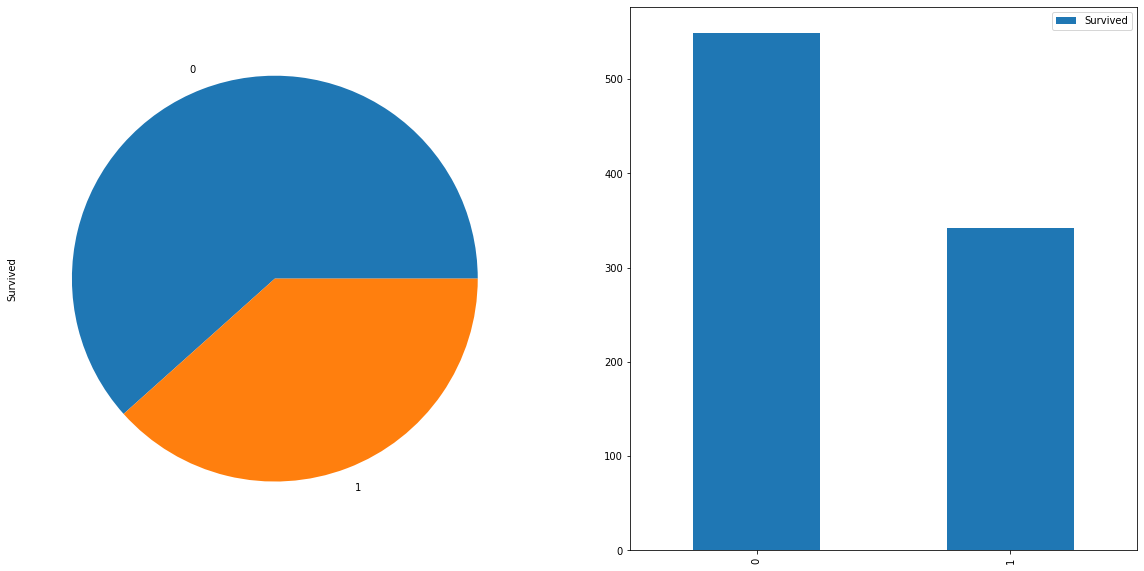

In [791]:
if SHOW_PROGRESS:
  fig, axes = plt.subplots(1, 2, figsize=(20, 10))
  (
    df_train['Survived']
    .value_counts() # this is a serious notebook, but if you comment this line, something funny happens
    .plot.pie(ax=axes[0])
  )
  (
    df_train['Survived']
    .value_counts() # this is a serious notebook, but if you comment this line, something funny happens
    .plot.bar(ax=axes[1], legend=['Died', 'Survived'])
  )

As expected, we're working with a somewhat unbalanced dataset

### Correlation

How similar, statistically speaking, two values are.
Does one value change whenever another one does? Does it increase/decrease a proportional amount? If we have two features that represent almost the same information, one has to go.

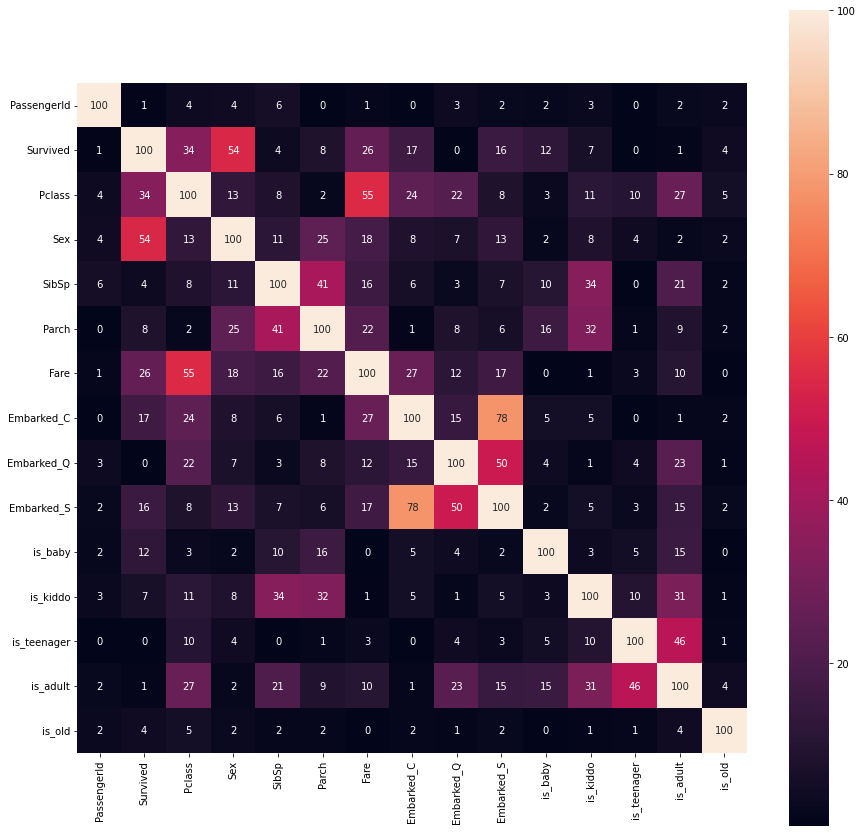

In [792]:
if SHOW_PROGRESS:
  plt.figure(figsize=(15, 15))
  sns.heatmap(df_train.corr().abs() * 100, annot=True, square=True, fmt='.0f')

Nothing too abnormally high, but if we were to do it by the book, either Pcass or Fare should be discarded.

Embarked_C is way too high, and I feel Embarked_C  is also very poorly distributed. But I feel that, ultimately, Embarked_S, is the one to go since it's the one with the lowest correlation with Survived

In [793]:
def remove_highly_correlated(
  dataframe: pd.DataFrame
) -> pd.DataFrame:
  df = dataframe.copy(deep=True)
  df = df.drop(columns=['Embarked_S'])

  return df

In [794]:
df_train = remove_highly_correlated(df_train)
df_test = remove_highly_correlated(df_test)

### Variable explainability

Let's see if we can explain or plot the dependant variable, if there's any independant feature that could explain the survivance

Sex had the highest correlation with Survived while not being too high

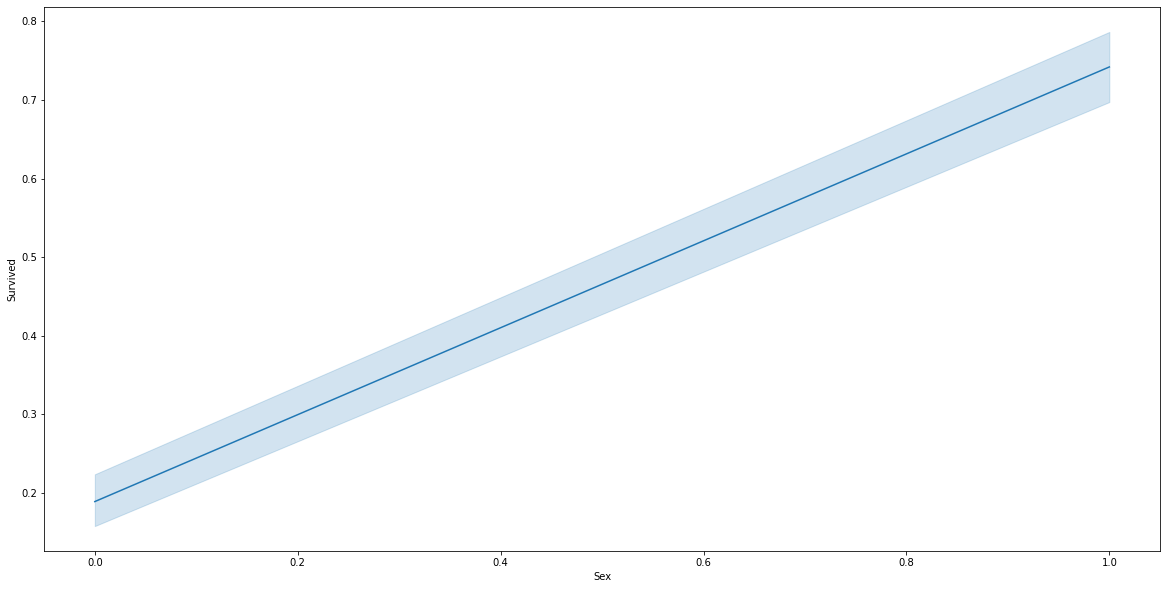

In [795]:
if SHOW_PROGRESS:
  plt.figure(figsize=(20, 10))
  sns.lineplot(data=df_train, x='Sex', y='Survived')

Plotting them all at once can help a great deal to see the impact at once

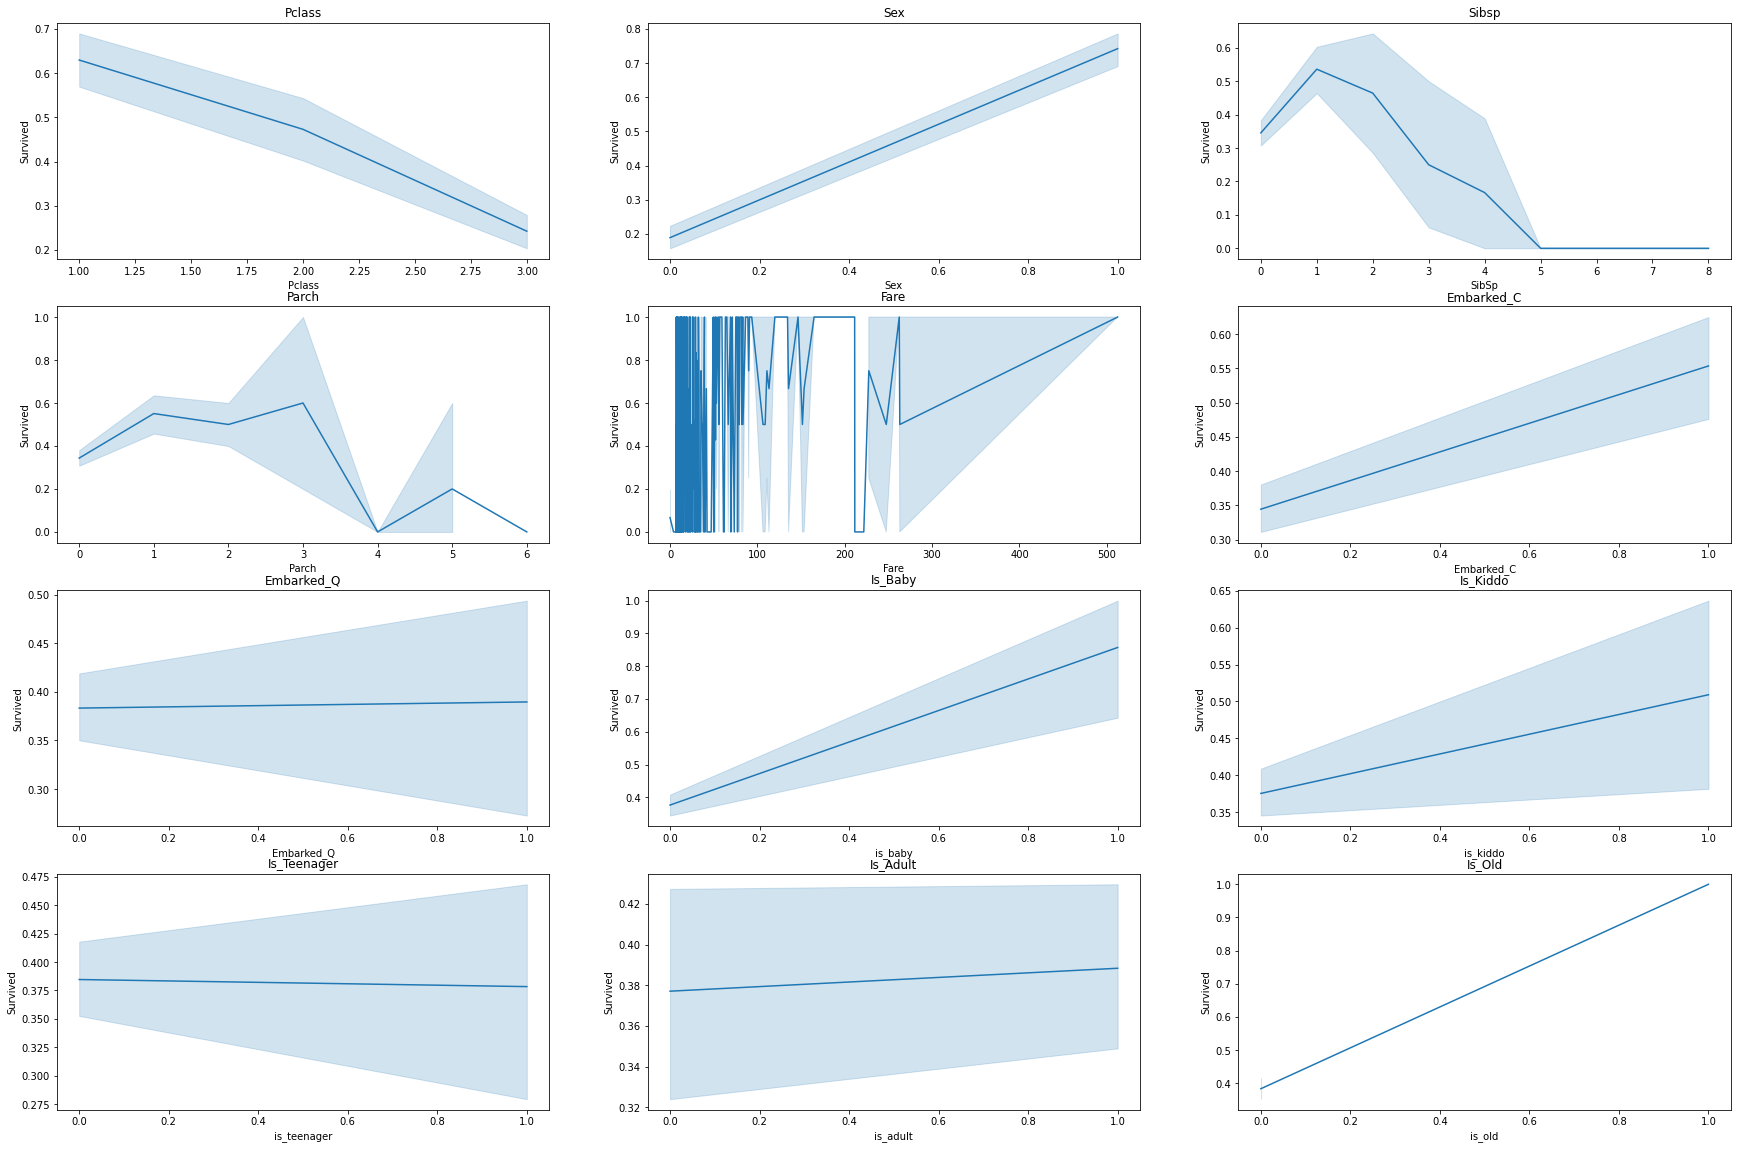

In [796]:
if SHOW_PROGRESS:
  columns = [ col for col in df_train.columns if col not in ['Survived', 'PassengerId'] ]
  n_cols = 3
  n_rows = ceil(len(columns) / n_cols)
  fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 10, n_rows * 5))
  for index, column in enumerate(columns):
    ax = axes[int(index / n_cols), int(index % n_cols)]
    ax.set_title(column.title())
    # sns.lineplot(data=df_train, x='Sex', y='Survived', ax=ax)
    # sns.scatterplot(data=df_train, x=column, y='Survived', ax=ax)
    sns.lineplot(data=df_train, x=column, y='Survived', ax=ax)

We can observe that some values help more than others, but, in some way or another, almost every single one contributes

## Hypothesis

My hypothesis for this dataset is that, women and children will have a higher rate of survivance because they used to be the first to be saved in case of emergency

But first! let's prepare a dataframe to visualize better

In [797]:
temp_df_train = df_train.copy(deep=True)
reverse_sex_dict = { value: key.title() for key, value in sex_dict.items() }
temp_df_train['Sex'] = temp_df_train['Sex'].apply(lambda x: reverse_sex_dict[x])
suvivance_dict = { 0: 'Dead', 1: 'Alive' }

### Gender suvivance

As aforementioned, the sex contributes to the explainability

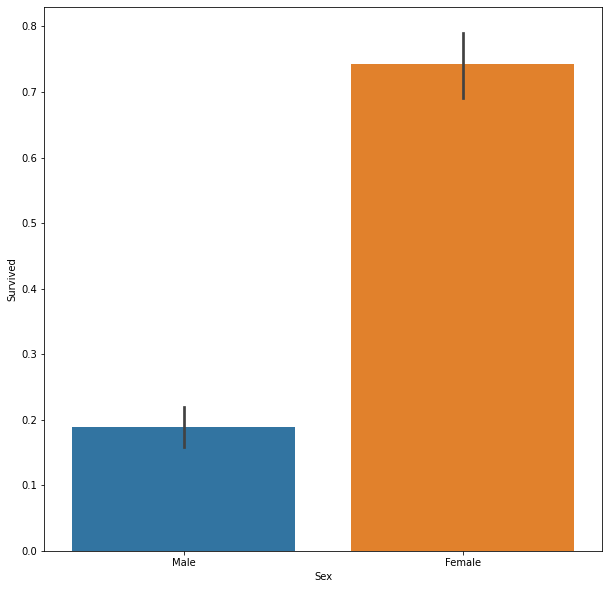

In [798]:
if SHOW_PROGRESS:
  plt.figure(figsize=(10, 10))
  sns.barplot(data=temp_df_train, x='Sex', y='Survived')

In [799]:
# temp_df_train['Survived'] = temp_df_train['Survived'].apply(lambda x: suvivance_dict[x])

### Age survivance

Some ages group also had a noticeable correlation, we can also combine it with the gender for a more insightful research

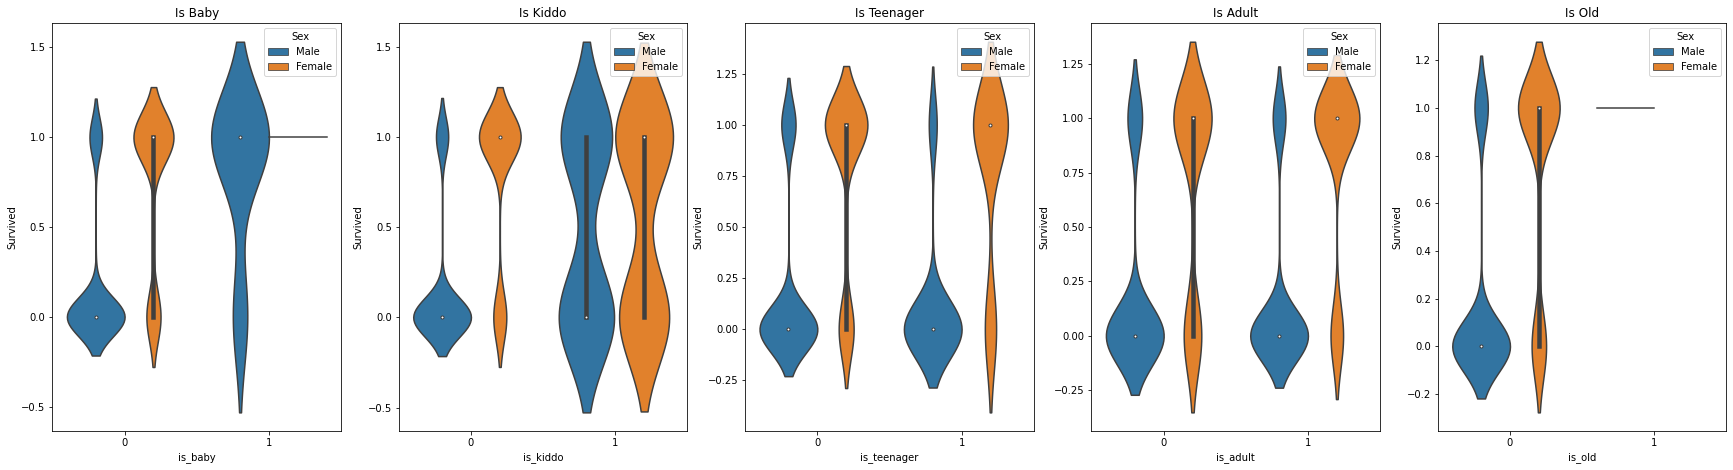

In [800]:
if SHOW_PROGRESS:
  fig, axes = plt.subplots(1, 5, figsize=(30, 7.5))

  # Reference guide
  # Zero equals No
  # One equals Yes

  age_columns = ['is_baby', 'is_kiddo', 'is_teenager', 'is_adult', 'is_old']
  for index, column in enumerate(age_columns):
    ax = axes[index]
    sns.violinplot(
      data=temp_df_train,
      x=column,
      y='Survived',
      hue='Sex',
      ax=ax,
      ci=None,
    )
    ax.set_title(column.replace('_', ' ').title())

A barplot is usually far easier to understand than a violinplot. But it's always a good idea to have the options you may require

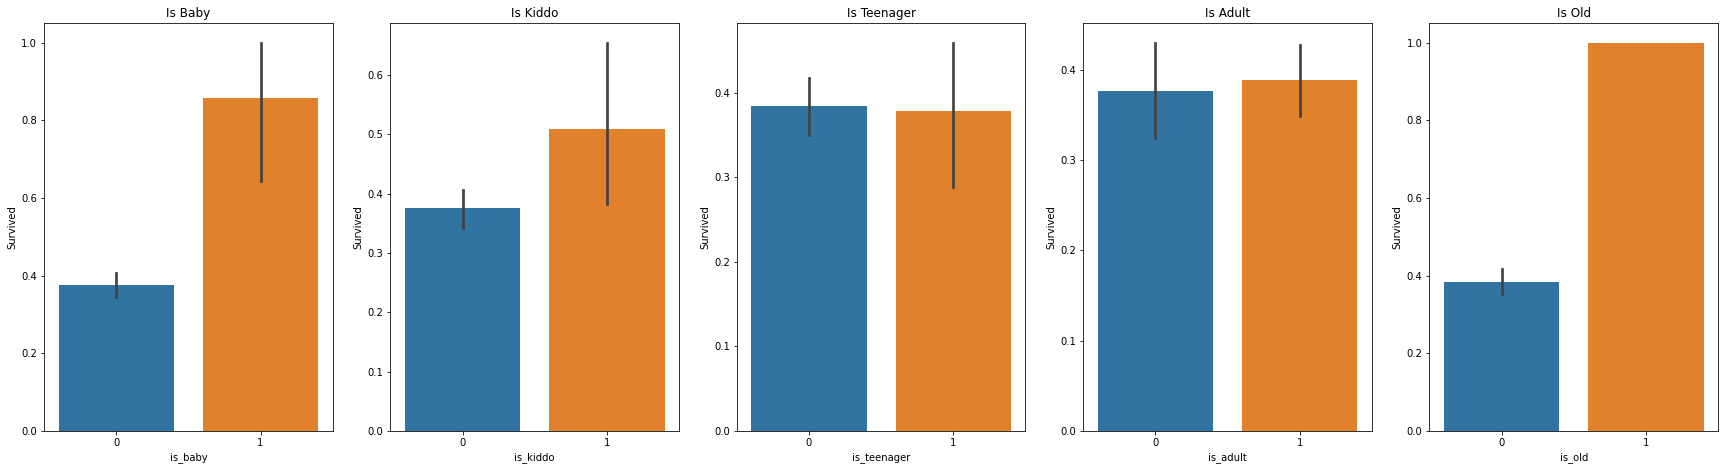

In [801]:
if SHOW_PROGRESS:
  fig, axes = plt.subplots(1, 5, figsize=(30, 7.5))
  for index, column in enumerate(age_columns):
    ax = axes[index]
    sns.barplot(
      data=temp_df_train,
      x=column,
      y='Survived',
      # hue='Sex',
      ax=ax,
      # ci=None,
    )
    ax.set_title(column.replace('_', ' ').title())

Depending on the age group it varies, but baby, kids and old people seem to have a high a correlation

#### Embarked survivance

Embarked had some classes with a high correlation

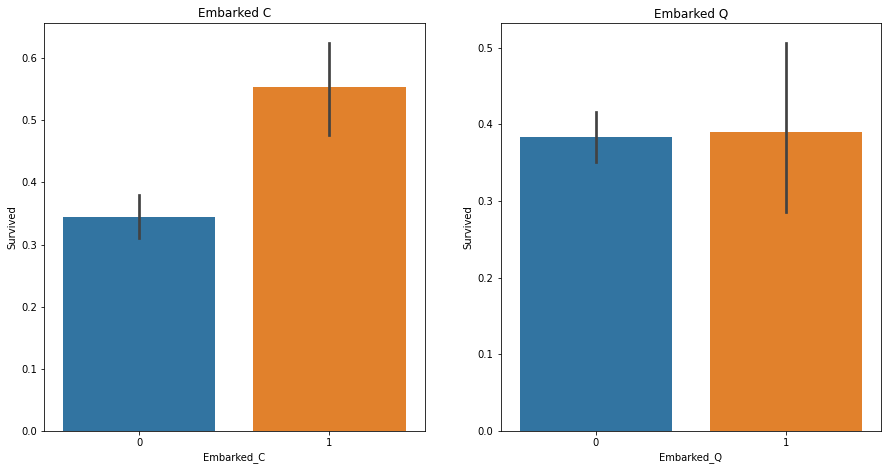

In [802]:
if SHOW_PROGRESS:
  embarked_columns = [ col for col in df_train.columns if col.startswith('Embarked') ]
  fig, axes = plt.subplots(1, len(embarked_columns), figsize=(len(embarked_columns) * 7.5, 7.5))
  for index, column in enumerate(embarked_columns):
    ax = axes[index]
    sns.barplot(
      data=temp_df_train,
      x=column,
      y='Survived',
      # hue='Sex',
      ax=ax,
      # ci=None,
    )
    ax.set_title(column.replace('_', ' ').title())

While Embarked_Q has some sort of correlation, Embared_C has a clear and distinct survivance rate

## Data Science

Data science is all about choosing the right algorithm and tuning it to it's best performance, well, the second part, the first one is to prepare the data so it's as optimal as possible for the algorithm(s) that you may wanna use.

### Imports

In [803]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score, roc_auc_score

### Assignment

I'm ignoring the PassengerId since it doesn't really give too much information, and an ID shouldn't really go into the model, most of the times. In this case, serving the purpose of a unique identifier, it's not necessary

In [804]:
ignore = ['Survived', 'PassengerId']
feature_columns = [ col for col in df_train.select_dtypes(include=np.number).columns if col not in ignore ]

In [805]:
X_train = df_train[feature_columns]
y_train = df_train['Survived']

In [806]:
X_test = df_test[feature_columns]

### Imbalancement

We already saw the imbalamcent, it is not huge, it is something we could even work around, but it's always better to fix it, and we'll do so by undersampling the majority label

In [807]:
FIX_IMBALANCEMENT = True #@param {type:'boolean'}

In [808]:
if FIX_IMBALANCEMENT:
  X_train, y_train = RandomUnderSampler(random_state=RANDOM_SEED).fit_resample(X_train, y_train)

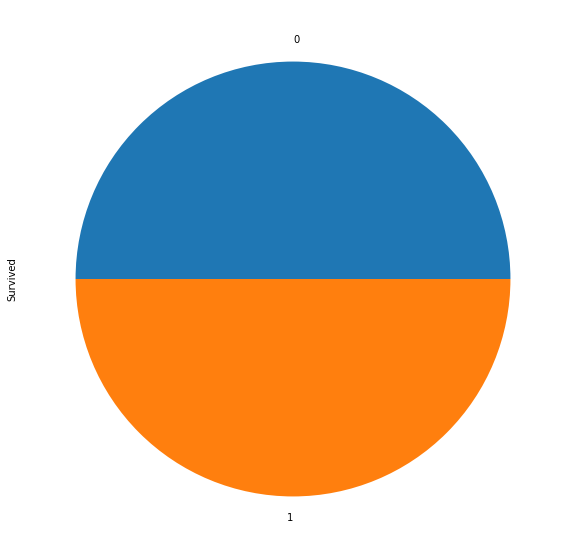

In [809]:
if SHOW_PROGRESS and FIX_IMBALANCEMENT:
  plt.figure(figsize=(10, 10))
  y_train.value_counts().plot.pie()

In [810]:
y_train.value_counts()

0    342
1    342
Name: Survived, dtype: int64

### Splitting

Splitting the data between two sets, one for training and another for validation is something pretty common, we already have a test set, but without labels.

What's new here is that we have to "stratify" our label class, we've balanced the dataset, and so it's crucial that our training set is balanced after all.

In [811]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.2, random_state=RANDOM_SEED, stratify=y_train)

In [812]:
if FIX_IMBALANCEMENT:
  X_val, y_val = RandomUnderSampler(random_state=RANDOM_SEED).fit_resample(X_val, y_val)

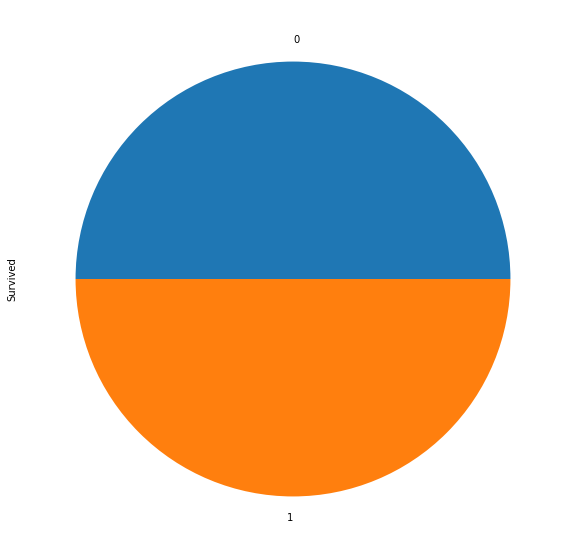

In [813]:
if SHOW_PROGRESS and FIX_IMBALANCEMENT:
  plt.figure(figsize=(10, 10))
  y_val.value_counts().plot.pie()

## Algorithms

Now that we've prepared the data, balanced it, cleaned it, it's time to choose a couple of algorithms and tune them.

It's important to keep in mind that we'll be doing binary classification. Some algorithms may perform better at multiclass, others at binary, and some at both

### Logistic Regression

Linear regression for classification, it's as "simple" as it's regression counterpart, but simple doesn't mean less effective

In [814]:
from sklearn.linear_model import LogisticRegression

def logistic_regression() -> Pipeline:
  return make_pipeline(
    MinMaxScaler(),
    LogisticRegression(random_state=RANDOM_SEED)
  )

In [815]:
clf_log = logistic_regression()
clf_log.fit(X_train, y_train)
print(clf_log.score(X_val, y_val))
y_pred_clf_log = clf_log.predict(X_val)
preds_proba_log = clf_log.predict_proba(X_val)[:, 1]
print(balanced_accuracy_score(y_val, y_pred_clf_log))

0.7279411764705882
0.7279411764705883


#### Confusion Matrix

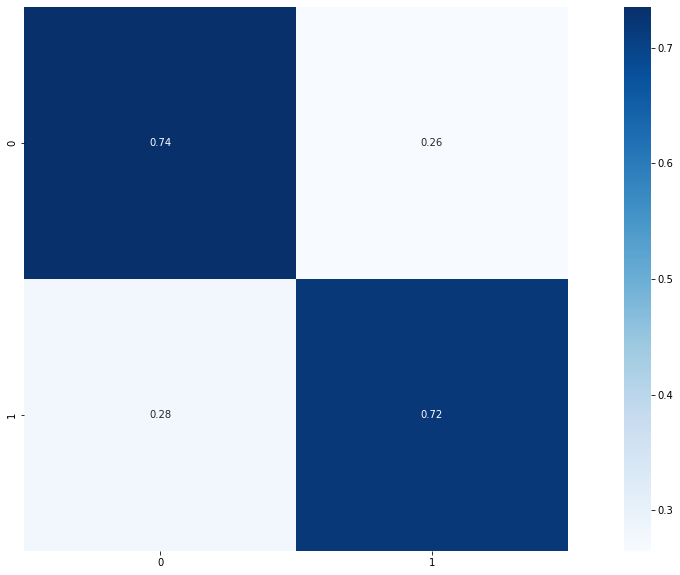

In [816]:
if SHOW_PROGRESS:
  df_cm = confusion_matrix(y_val, y_pred_clf_log)
  df_cm = df_cm.astype('float') / df_cm.sum(axis = 1)[:, np.newaxis]
  plt.figure(figsize=(20, 10))
  sns.heatmap(df_cm, square=True, annot=True, fmt='.2f', cmap='Blues')

In [817]:
if SHOW_PROGRESS:
  print(classification_report(y_val, y_pred_clf_log))
  print(f'ROC AUC Score: {round(roc_auc_score(y_val, preds_proba_log), 2)}')

              precision    recall  f1-score   support

           0       0.72      0.74      0.73        68
           1       0.73      0.72      0.73        68

    accuracy                           0.73       136
   macro avg       0.73      0.73      0.73       136
weighted avg       0.73      0.73      0.73       136

ROC AUC Score: 0.82


#### Explainability

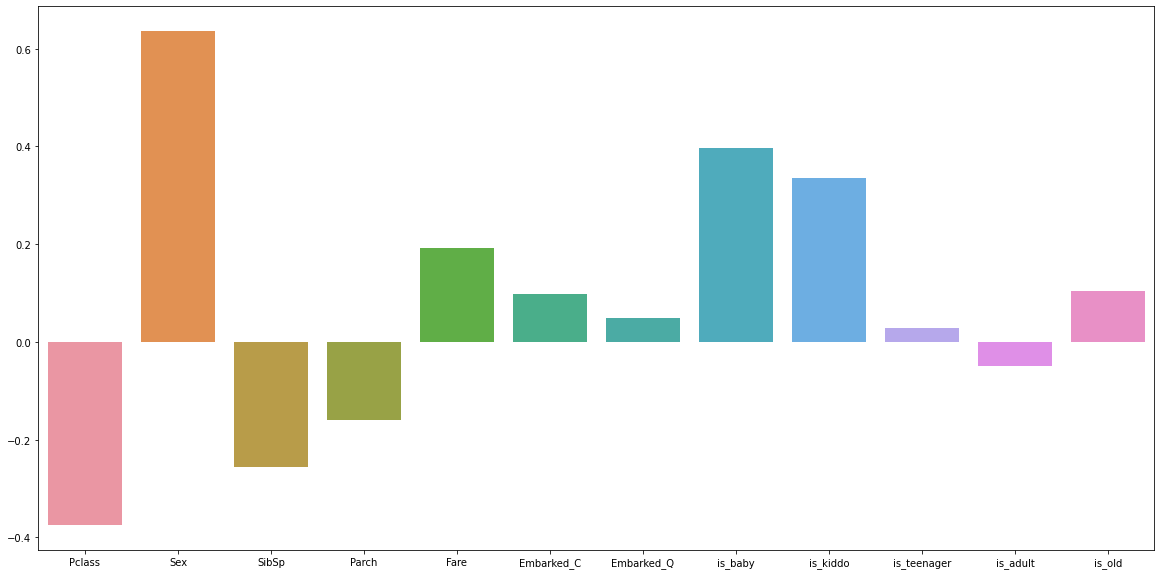

In [818]:
df_coefficients = pd.DataFrame(clf_log['logisticregression'].coef_, columns=feature_columns)
df_coefficients = df_coefficients / df_coefficients.values.sum()
plt.figure(figsize=(20, 10))
sns.barplot(data=df_coefficients)

### XGBoost

A gradient boosted regularized technique that performs really well for multiple scenarios, binary being on of them.

In [819]:
from xgboost import XGBClassifier

def xgboost_classifier() -> Pipeline:
  return make_pipeline(
    MinMaxScaler(),
    XGBClassifier(random_state=RANDOM_SEED)
  )

In [820]:
clf_xgboost = xgboost_classifier()
clf_xgboost.fit(X_train, y_train)
print(clf_xgboost.score(X_val, y_val))
y_pred_clf_xgboost = clf_xgboost.predict(X_val)
preds_proba_xgboost = clf_xgboost.predict_proba(X_val)[:, 1]
print(balanced_accuracy_score(y_val, y_pred_clf_xgboost))

0.7426470588235294
0.7426470588235294


#### Confusion Matrix

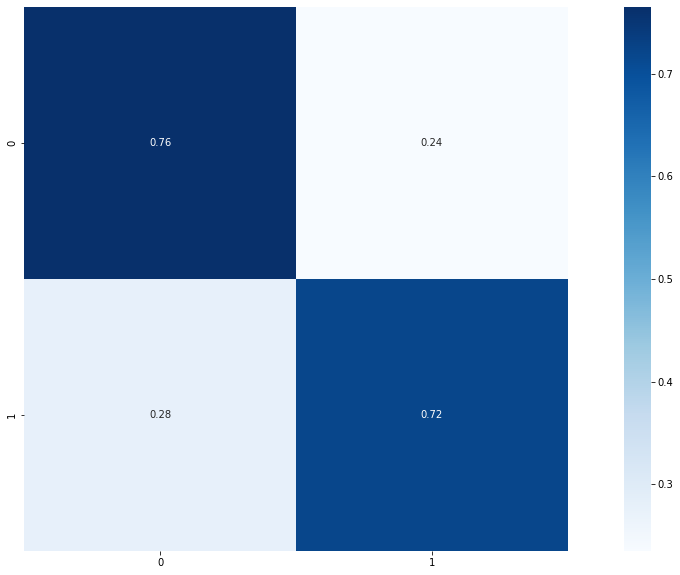

In [821]:
if SHOW_PROGRESS:
  df_cm = confusion_matrix(y_val, y_pred_clf_xgboost)
  df_cm = df_cm.astype('float') / df_cm.sum(axis = 1)[:, np.newaxis]
  plt.figure(figsize=(20, 10))
  sns.heatmap(df_cm, square=True, annot=True, fmt='.2f', cmap='Blues')

In [822]:
if SHOW_PROGRESS:
  print(classification_report(y_val, y_pred_clf_xgboost))
  print(f'ROC AUC Score: {round(roc_auc_score(y_val, preds_proba_xgboost), 2)}')

              precision    recall  f1-score   support

           0       0.73      0.76      0.75        68
           1       0.75      0.72      0.74        68

    accuracy                           0.74       136
   macro avg       0.74      0.74      0.74       136
weighted avg       0.74      0.74      0.74       136

ROC AUC Score: 0.84


### RandomForest

A forest of decission trees that chooses the tree with the best performance

In [823]:
from sklearn.ensemble import RandomForestClassifier

def random_forest_classifier() -> Pipeline:
  return make_pipeline(
    MinMaxScaler(),
    RandomForestClassifier(n_estimators=5, random_state=RANDOM_SEED)
  )

In [824]:
clf_rfc = random_forest_classifier()
clf_rfc.fit(X_train, y_train)
print(clf_rfc.score(X_val, y_val))
y_pred_clf_rfc = clf_rfc.predict(X_val)
preds_proba_rfc = clf_rfc.predict_proba(X_val)[:, 1]
print(balanced_accuracy_score(y_val, y_pred_clf_rfc))

0.7794117647058824
0.7794117647058824


#### Confusion Matrix

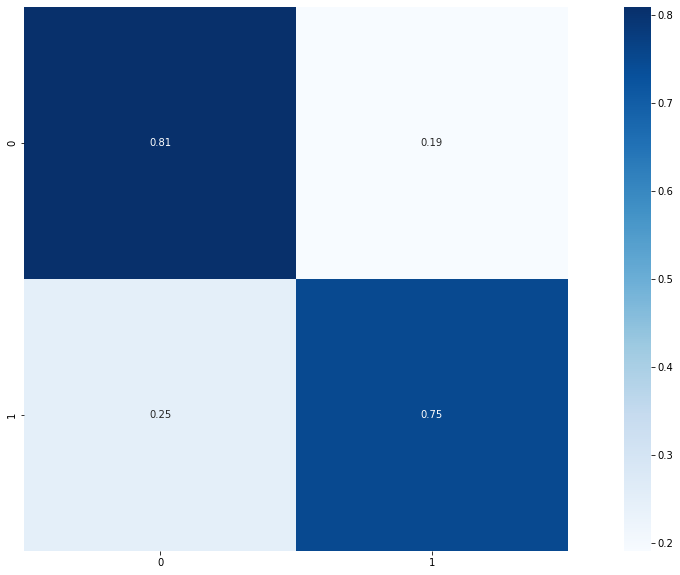

In [825]:
if SHOW_PROGRESS:
  df_cm = confusion_matrix(y_val, y_pred_clf_rfc)
  df_cm = df_cm.astype('float') / df_cm.sum(axis = 1)[:, np.newaxis]
  plt.figure(figsize=(20, 10))
  sns.heatmap(df_cm, square=True, annot=True, fmt='.2f', cmap='Blues')

In [826]:
if SHOW_PROGRESS:
  print(classification_report(y_val, y_pred_clf_rfc))
  print(f'ROC AUC Score: {round(roc_auc_score(y_val, preds_proba_rfc), 2)}')

              precision    recall  f1-score   support

           0       0.76      0.81      0.79        68
           1       0.80      0.75      0.77        68

    accuracy                           0.78       136
   macro avg       0.78      0.78      0.78       136
weighted avg       0.78      0.78      0.78       136

ROC AUC Score: 0.79


#### Explainability

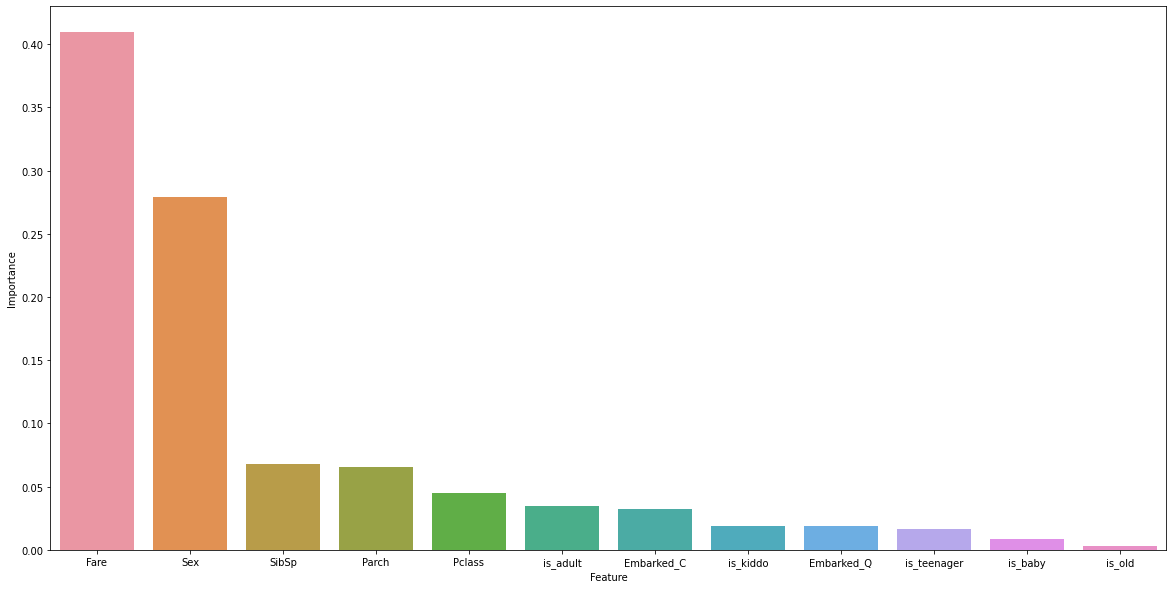

In [827]:
if SHOW_PROGRESS:
  df_features = pd.DataFrame(
    zip(feature_columns, clf_rfc['randomforestclassifier'].feature_importances_),
    columns=['Feature', 'Importance']
  ).sort_values(by='Importance', ascending=False)
  plt.figure(figsize=(20, 10))
  sns.barplot(data=df_features, x='Feature', y='Importance')

## Results

In [828]:
SUBMISSION_ROWS = 418 #@param {type:'integer'}

### Proper submission dataset generation

In [829]:
df_gender_submission = pd.read_csv('gender_submission.csv')
df_gender_submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [830]:
df_full_dataset = df_test.copy(deep=True)

We can check that the test set is the same than the sample gender submissions one

In [831]:
len(df_full_dataset[ df_full_dataset['PassengerId'].isin(df_gender_submission['PassengerId']) ])

418

Since we're working with a newly created dataset, we need to select the features that we want

In [832]:
df_submission = df_full_dataset[ [ 'PassengerId', *feature_columns ] ]

I'm using the Random Forest Classifier because, even though it has bias (all of them have), it's the one that, more consistently, fails the least

In [833]:
df_submission['Survived'] = clf_rfc.predict(df_submission[feature_columns])
df_submission = df_submission[ ['PassengerId', 'Survived'] ]
df_submission.head(5)

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,0


We can check that it has no missing values whatsoever

In [834]:
df_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   PassengerId  418 non-null    int64
 1   Survived     418 non-null    int64
dtypes: int64(2)
memory usage: 6.7 KB


We'll save it without the index, this step is crucial

In [835]:
filename = 'balanced-predictions.csv' if FIX_IMBALANCEMENT else 'true-titanic-predictions.csv'
df_submission.to_csv(filename, index=False)

And we'll assert that, we have the required number of rows for our submission, and all of the passenger ids are non-duplicates

In [836]:
assert len(df_submission) == SUBMISSION_ROWS
assert len(df_submission['PassengerId'].unique()) == SUBMISSION_ROWS

Once done that, we can submit our predictions to the leaderboard, while it won't be the highest score, it will be decent enough.

In [837]:
if SUBMIT_ANSWER:
  assert len(df_submission) == SUBMISSION_ROWS

  if FIX_IMBALANCEMENT:
    # !kaggle competitions submit -c titanic -f true-titanic-predictions.csv -m "Balancing the dataset, analyzing it's correlation, and, using the min max normalization, apply XGBoost"
    !kaggle competitions submit -c titanic -f true-titanic-predictions.csv -m "Balancing the dataset, analyzing it's correlation, and, using the min max normalization, apply RandomForest"
  else:
    !kaggle competitions submit -c titanic -f true-titanic-predictions.csv -m "Using the min max normalization and then applying XGBoost"

You can now see your Kaggle configuration

In [838]:
!kaggle config view

Configuration values from /root/.kaggle
- username: jofaval
- path: None
- proxy: None
- competition: None


## Conclusions

To wrap it up, this will be a sumarized, since there's also not that much to conclude.

### Balancement

Balance your datasets! It's really important and a challenge. It's also a must towards creating unbiased models. It "lowered" the score quite a bit. But it's less unbiased, though it's still biased, I feel that more training data would be required to have less bias and a higher performance.

### Survivance explainability

We were able to explain a bit the survivance, moreover, we hypothesized correctly, sex and age does have a lot to do with the survivance, and so does the embarking class.